## Enhanced Multimodel Hand gesture recognition

In [1]:
expression_to_gesture = {
        'angry': list([0,1,2,3]),
        'fear': list([4,5,6,7]),
        'happy': list([8,9,10,11,12]),
        'neutral': list([13,14,15,16]),
        'sad': list([17,18,19,20]),
        'surprise': list([21,22,23,24])
    }

In [2]:
import os
import pandas as pd
import numpy as np 
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random



def load_hand_gestures(csv_file):
    df = pd.read_csv(csv_file)
    images = df.drop('label', axis=1).values.reshape(-1, 28, 28).astype(np.uint8)  # Assuming images are 28x28
    labels = df['label'].values
    return images, labels


def load_facial_expressions(base_dir):
    expressions = {}
    for expression in os.listdir(base_dir):
        if expression == 'disgust':
            continue  # Skip disgust images
        expression_path = os.path.join(base_dir, expression)
        if os.path.isdir(expression_path):
            expressions[expression] = [os.path.join(expression_path, file) for file in os.listdir(expression_path)]
    return expressions

class CombinedDataset(Dataset):
    def __init__(self, hand_images, hand_labels, face_expressions, transform=None):
        self.hand_images = hand_images
        self.hand_labels = hand_labels
        self.face_expressions = face_expressions
        self.transform = transform
        self.expression_to_gesture = {
        'angry': list([0,1,2,3]),
        'fear': list([4,5,6,7]),
        'happy': list([8,9,10,11,12]),
        'neutral': list([13,14,15,16]),
        'sad': list([17,18,19,20]),
        'surprise': list([21,22,23,24])
    }
        self.expression_to_number = {
            'angry': 0,
            'fear': 1,
            'happy': 2,
            'neutral': 3,
            'sad': 4,
            'surprise': 5
        }

    def __len__(self):
        return len(self.hand_labels)

    def __getitem__(self, idx):
        hand_image = self.hand_images[idx]
        label = self.hand_labels[idx]
        expression = next((exp for exp, gestures in self.expression_to_gesture.items() if label in gestures), None)
        if expression is None:
            raise ValueError(f'No expression mapped for label {label} at index {idx}')

        if expression not in self.face_expressions or not self.face_expressions[expression]:
            raise ValueError(f'No facial expression images available for expression {expression}')

        face_image_path = np.random.choice(self.face_expressions[expression])
        face_image = Image.open(face_image_path).convert('L')

        if self.transform:
            hand_image = self.transform(Image.fromarray(hand_image))
            face_image = self.transform(face_image)
        return hand_image, face_image, label, self.expression_to_number[expression]

transform = transforms.Compose([
    transforms.Resize((28, 28)),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),  
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize((0.5,), (0.5,))
])


hand_gestures_csv = 'sign_language_mnist/sign_mnist_train/sign_mnist_train.csv'
facial_expressions_dir = 'facial_expressions_mnist/train'

hand_images, hand_labels = load_hand_gestures(hand_gestures_csv)
face_expressions = load_facial_expressions(facial_expressions_dir)
dataset = CombinedDataset(hand_images, hand_labels, face_expressions, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [3]:
pd.Series(dataset.__getitem__(0)).transpose()

0    [[[tensor(-1.), tensor(-1.), tensor(-1.), tens...
1    [[[tensor(-1.), tensor(-1.), tensor(-1.), tens...
2                                                    3
3                                                    0
dtype: object

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
hand_gesture_label_count = 25
face_expression_label_count = 6

In [6]:
for label in np.unique(hand_labels):
    expression = next((exp for exp, gestures in expression_to_gesture.items() if label in gestures), None)
    print(f'Label: {label}, Maps to: {expression}')


Label: 0, Maps to: angry
Label: 1, Maps to: angry
Label: 2, Maps to: angry
Label: 3, Maps to: angry
Label: 4, Maps to: fear
Label: 5, Maps to: fear
Label: 6, Maps to: fear
Label: 7, Maps to: fear
Label: 8, Maps to: happy
Label: 10, Maps to: happy
Label: 11, Maps to: happy
Label: 12, Maps to: happy
Label: 13, Maps to: neutral
Label: 14, Maps to: neutral
Label: 15, Maps to: neutral
Label: 16, Maps to: neutral
Label: 17, Maps to: sad
Label: 18, Maps to: sad
Label: 19, Maps to: sad
Label: 20, Maps to: sad
Label: 21, Maps to: surprise
Label: 22, Maps to: surprise
Label: 23, Maps to: surprise
Label: 24, Maps to: surprise


In [8]:
np.unique(hand_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualInputCNN(nn.Module):
    def __init__(self, hand_classes=25, face_classes=6):  # Adjusted for 25 classes
        super(DualInputCNN, self).__init__()
        # Hand gesture branch
        self.hand_cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Facial expression branch
        self.face_cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7 * 2, 512),  # Adjust size based on your input image size
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128)
        )
        self.fc_hand = nn.Sequential(
            nn.Linear(128, hand_classes)
        )

        self.fc_face = nn.Sequential(
            nn.Linear(128, face_classes)
        )

        self.dropout2 = nn.Dropout(0.2)
        self.dropout5 = nn.Dropout(0.5)

    def forward(self, hand_x, face_x):
        hand_features = self.dropout5(self.hand_cnn(hand_x))
        hand_features = hand_features.view(hand_features.size(0), -1)
        face_features = self.dropout5(self.face_cnn(face_x))
        face_features = face_features.view(face_features.size(0), -1)
        combined_features = torch.cat([hand_features, face_features], dim=1)
        output = self.dropout2(self.fc(combined_features))
        output_hand = self.fc_hand(output)
        output_face = self.fc_face(output)

        return output_hand, output_face



In [10]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("mps")
device

device(type='mps')

In [11]:
dual_input_model = DualInputCNN()
dual_input_model.to(device)

DualInputCNN(
  (hand_cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (face_cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6272, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
  )
  (fc_hand): Sequential(

In [12]:
import torch.optim as optim

def train_model(model, dataloader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train() 

    for epoch in range(num_epochs):
        running_loss = 0.0

        for i, (hand_images, face_images, labels, expression) in enumerate(dataloader):
            hand_images, face_images, labels, expression = hand_images.to(device), face_images.to(device), labels.to(device), expression.to(device)
            optimizer.zero_grad()

            outputs_hand, outputs_face = model(hand_images, face_images)
            # Training loss calculation
            loss = criterion(outputs_hand, labels) + criterion(outputs_face, expression)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1} loss: {running_loss / len(dataloader)}')

# Initialize the model
model = DualInputCNN()
model.to(device)

# Train the model
train_model(model, dataloader)


Epoch 1 loss: 3.0320881202226473
Epoch 2 loss: 1.243780847751733
Epoch 3 loss: 0.8021462804231888
Epoch 4 loss: 0.5338373369339741
Epoch 5 loss: 0.4368489552072156
Epoch 6 loss: 0.38538981427054303
Epoch 7 loss: 0.30195851016155767
Epoch 8 loss: 0.2561979875020631
Epoch 9 loss: 0.25549378794007926
Epoch 10 loss: 0.2886160862803598


In [13]:

hand_gestures_test = 'sign_language_mnist/sign_mnist_test/sign_mnist_test.csv'
facial_expressions_test_dir = 'facial_expressions_mnist/test'
hand_images_test, hand_labels_test = load_hand_gestures(hand_gestures_test)
face_expressions_test = load_facial_expressions(facial_expressions_test_dir)
dataset_test = CombinedDataset(hand_images_test, hand_labels_test, face_expressions_test, transform=test_transform)
testloader = DataLoader(dataset_test, batch_size=64, shuffle=True)


In [14]:

import seaborn as sns
import matplotlib.pyplot as plt
def plot_cm(cm, label_count):
    class_names = list(range(label_count))
    plt.figure(figsize=(20, 15))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Classes')
    plt.xlabel('Predicted Classes')
    plt.show()


torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 2

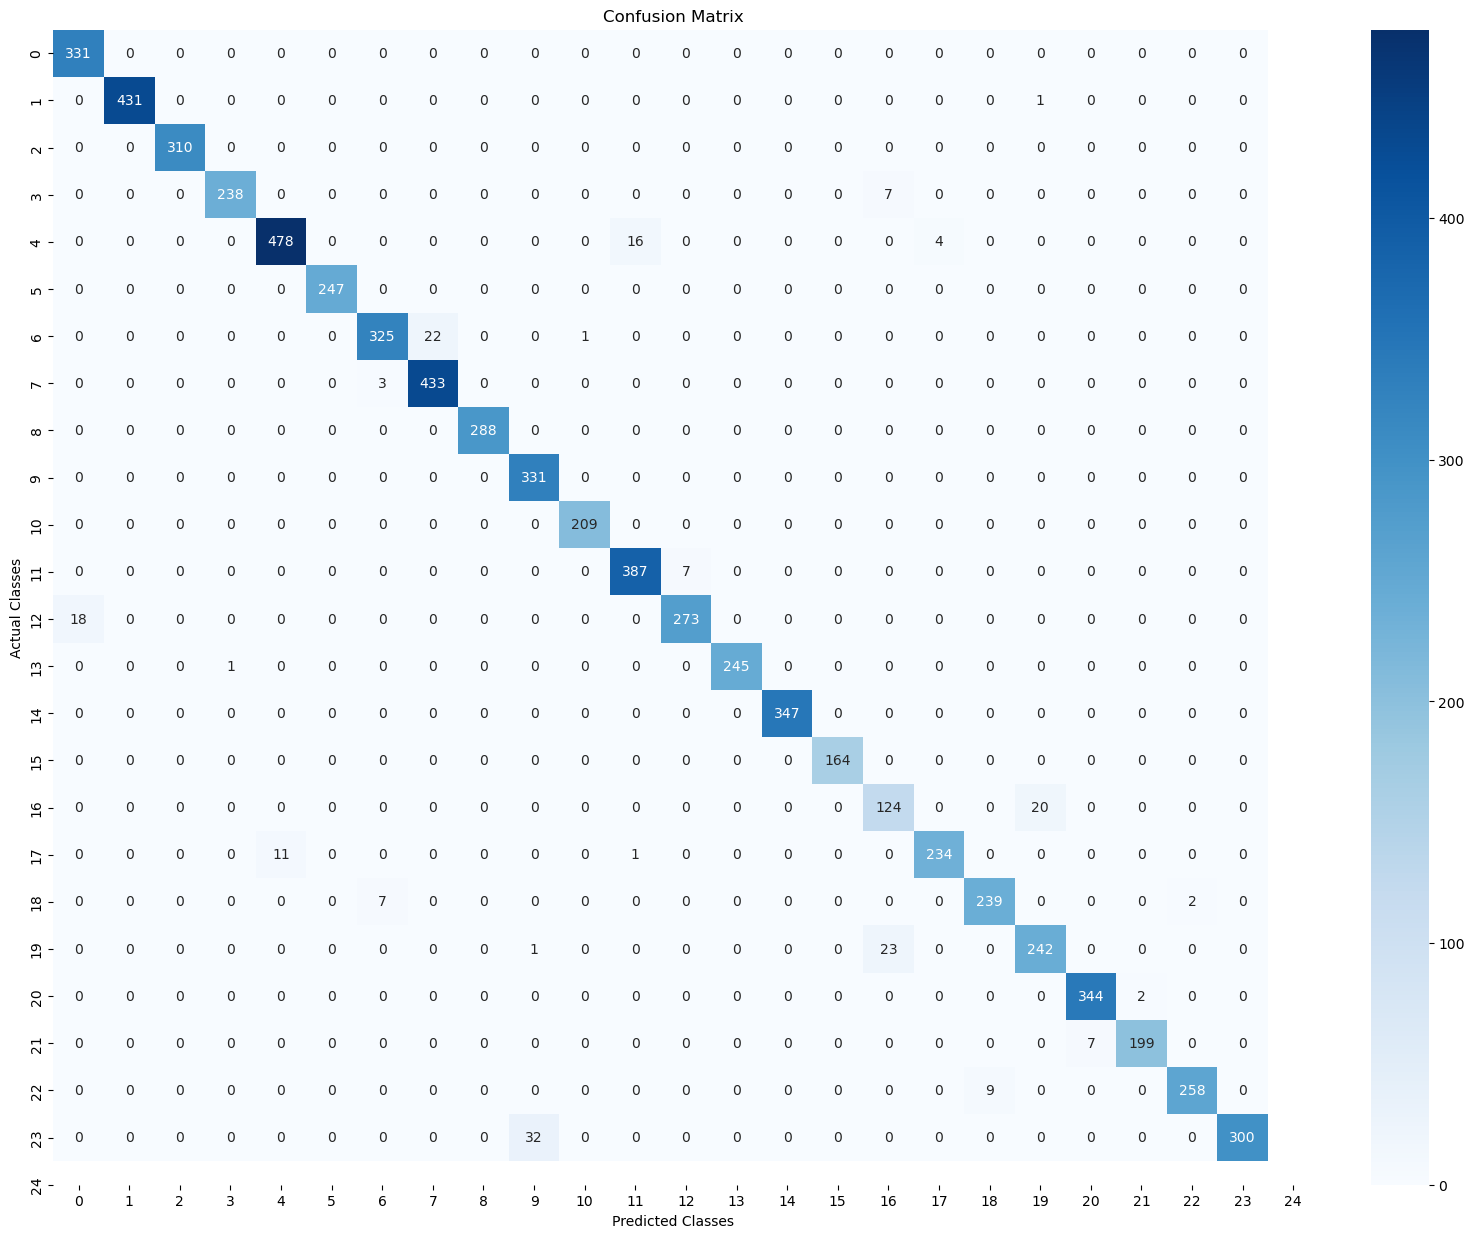

Accuracy Score:
0.9728109313998885
FACE EMOTION
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1318
           1       0.98      0.97      0.98      1529
           2       0.94      0.99      0.96      1222
           3       0.98      1.00      0.99      1048
           4       0.97      0.96      0.97       904
           5       0.99      0.96      0.97      1151

    accuracy                           0.98      7172
   macro avg       0.98      0.98      0.98      7172
weighted avg       0.98      0.98      0.98      7172

Confusion Matrix:


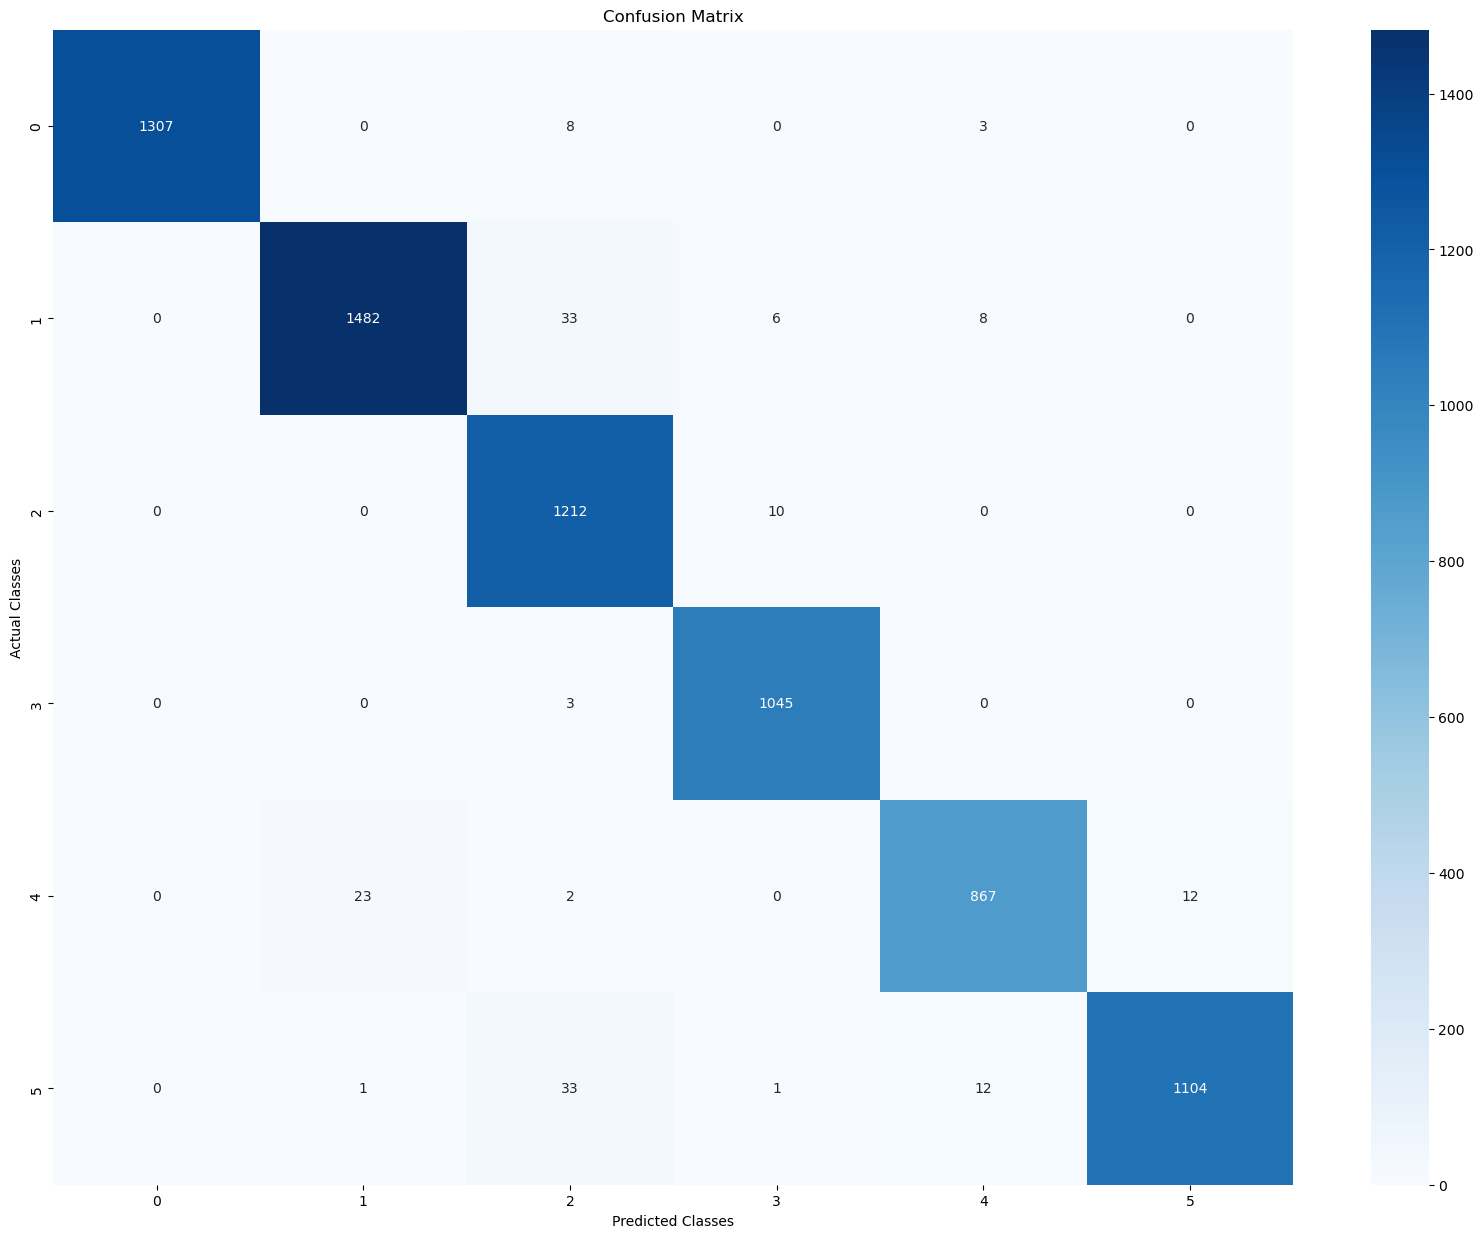

Accuracy Score:
0.978388176240937


In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()
    all_predictions_hand = []
    all_labels_hand = []

    all_predictions_face = []
    all_labels_face = []

    with torch.no_grad():
        test_loss = 0.0
        for i, (hand_images, face_images, labels, expression) in enumerate(dataloader):
            hand_images, face_images, labels, expression = hand_images.to(device), face_images.to(device), labels.to(device), expression.to(device)
            print(hand_images.shape, face_images.shape)
            outputs_hand, outputs_face = model(hand_images, face_images)

            _, predicted = torch.max(outputs_hand, 1)
            all_predictions_hand.extend(predicted.cpu().numpy())
            all_labels_hand.extend(labels.cpu().numpy())

            _, predicted = torch.max(outputs_face, 1)
            all_predictions_face.extend(predicted.cpu().numpy())
            all_labels_face.extend(expression.cpu().numpy())


    print("HAND GESTURE RECOGNITION")
    print("Classification Report:")
    print(classification_report(all_labels_hand, all_predictions_hand))
    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels_hand, all_predictions_hand)
    plot_cm(cm, hand_gesture_label_count)
    print("Accuracy Score:")
    print(accuracy_score(all_labels_hand, all_predictions_hand))

    print("FACE EMOTION")
    print("Classification Report:")
    print(classification_report(all_labels_face, all_predictions_face))
    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels_face, all_predictions_face)
    plot_cm(cm, face_expression_label_count)
    
    print("Accuracy Score:")
    print(accuracy_score(all_labels_face, all_predictions_face))

evaluate_model(model, testloader)


## Hyperparameter Tuning

In [16]:
# learning_rates = [ 0.0001, 0.001, 0.01]

def lr_train_model(lr_model, dataloader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(lr_model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9) 

    lr_model.train()  
    best_loss = float('inf')

    for epoch in range(num_epochs):
        running_loss = 0.0

        for i, (hand_images, face_images, labels, expression) in enumerate(dataloader):
            hand_images, face_images, labels, expression = hand_images.to(device), face_images.to(device), labels.to(device), expression.to(device)

            optimizer.zero_grad()

            outputs_hand, outputs_face = lr_model(hand_images, face_images)


            loss = criterion(outputs_hand, labels) + criterion(outputs_face, expression)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        print(f'LR Model Epoch {epoch+1} - Learning rate: {scheduler.get_last_lr()[0]}  loss: {epoch_loss}')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(lr_model.state_dict(), 'best_fusion_model.pth')

        scheduler.step() 

lr_model = DualInputCNN()
lr_model.to(device)

lr_train_model(lr_model, dataloader, num_epochs=10)



LR Model Epoch 1 - Learning rate: 0.001  loss: 3.170648295284707
LR Model Epoch 2 - Learning rate: 0.001  loss: 1.4028184009598685
LR Model Epoch 3 - Learning rate: 0.001  loss: 0.8549288139615582
LR Model Epoch 4 - Learning rate: 0.0009000000000000001  loss: 0.5977839716386684
LR Model Epoch 5 - Learning rate: 0.0009000000000000001  loss: 0.44581397482148416
LR Model Epoch 6 - Learning rate: 0.0009000000000000001  loss: 0.4170824415755994
LR Model Epoch 7 - Learning rate: 0.0008100000000000001  loss: 0.33547931885246907
LR Model Epoch 8 - Learning rate: 0.0008100000000000001  loss: 0.29291841443324146
LR Model Epoch 9 - Learning rate: 0.0008100000000000001  loss: 0.2907429054587871
LR Model Epoch 10 - Learning rate: 0.000729  loss: 0.24958579576550385


torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 2

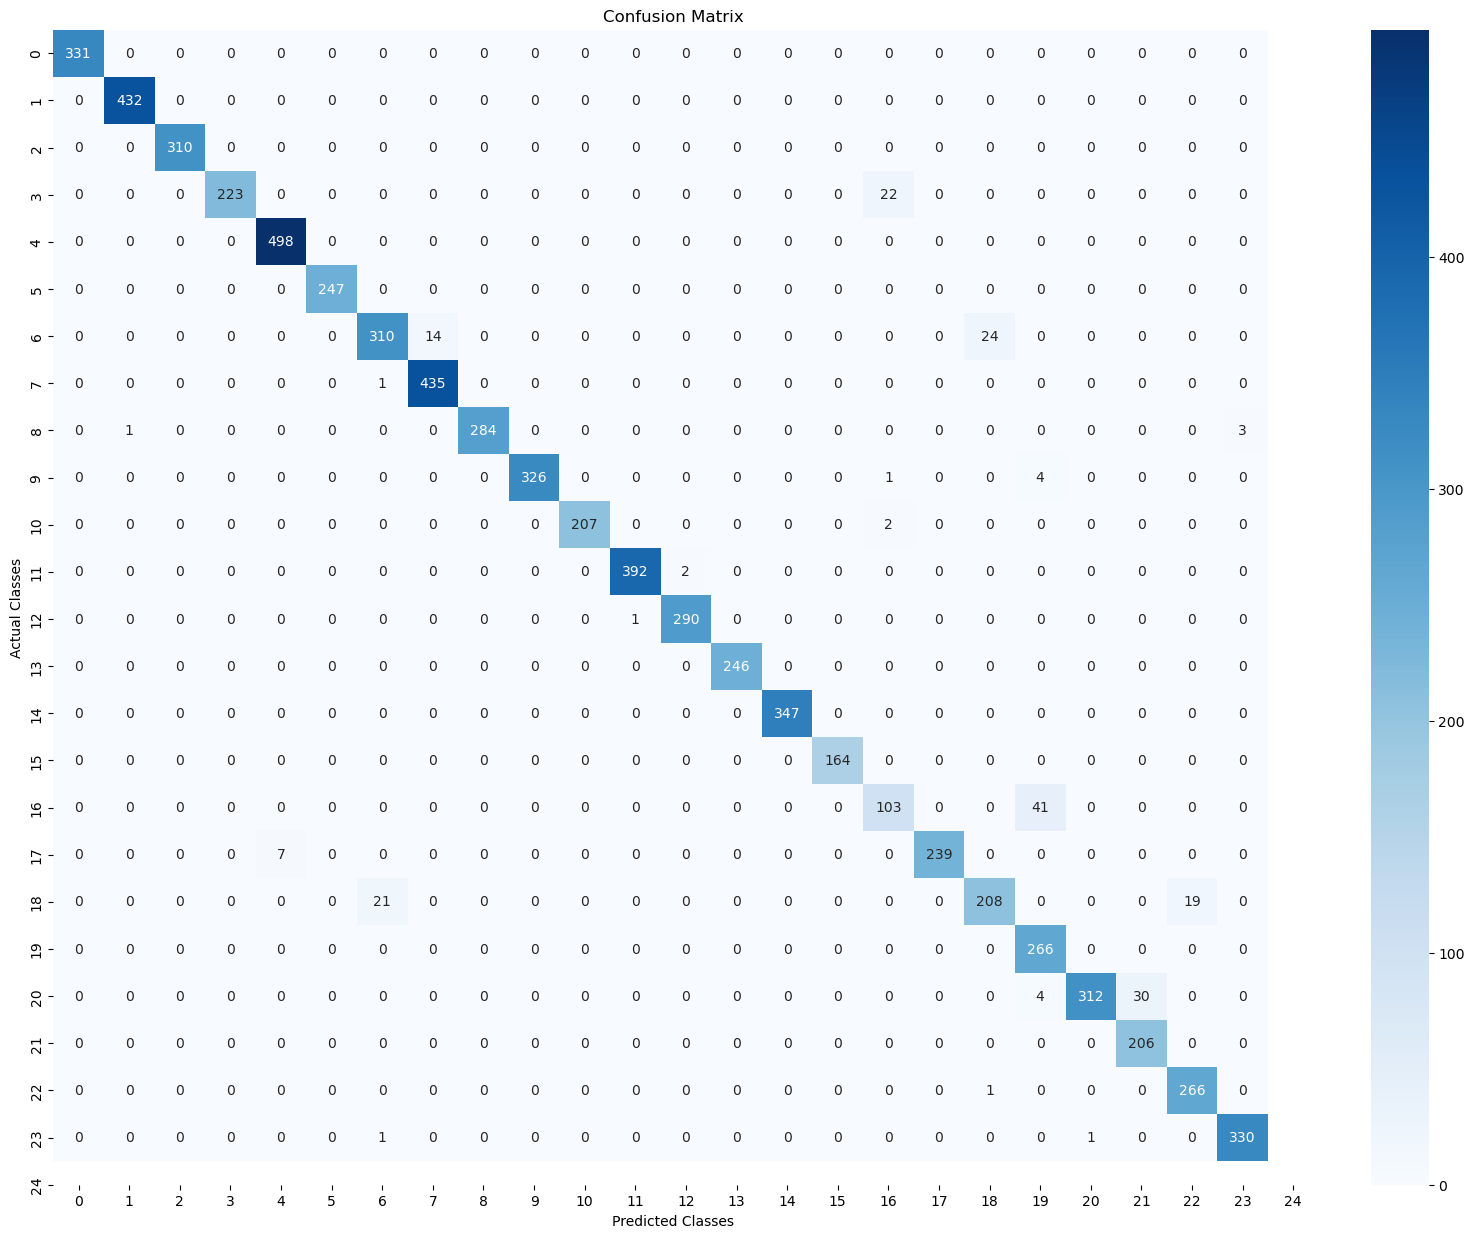

Accuracy Score:
0.9721137757947574
FACE EMOTION
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1318
           1       0.98      0.98      0.98      1529
           2       0.99      0.94      0.96      1222
           3       1.00      0.99      1.00      1048
           4       0.84      0.95      0.89       904
           5       0.98      0.98      0.98      1151

    accuracy                           0.97      7172
   macro avg       0.96      0.97      0.97      7172
weighted avg       0.97      0.97      0.97      7172

Confusion Matrix:


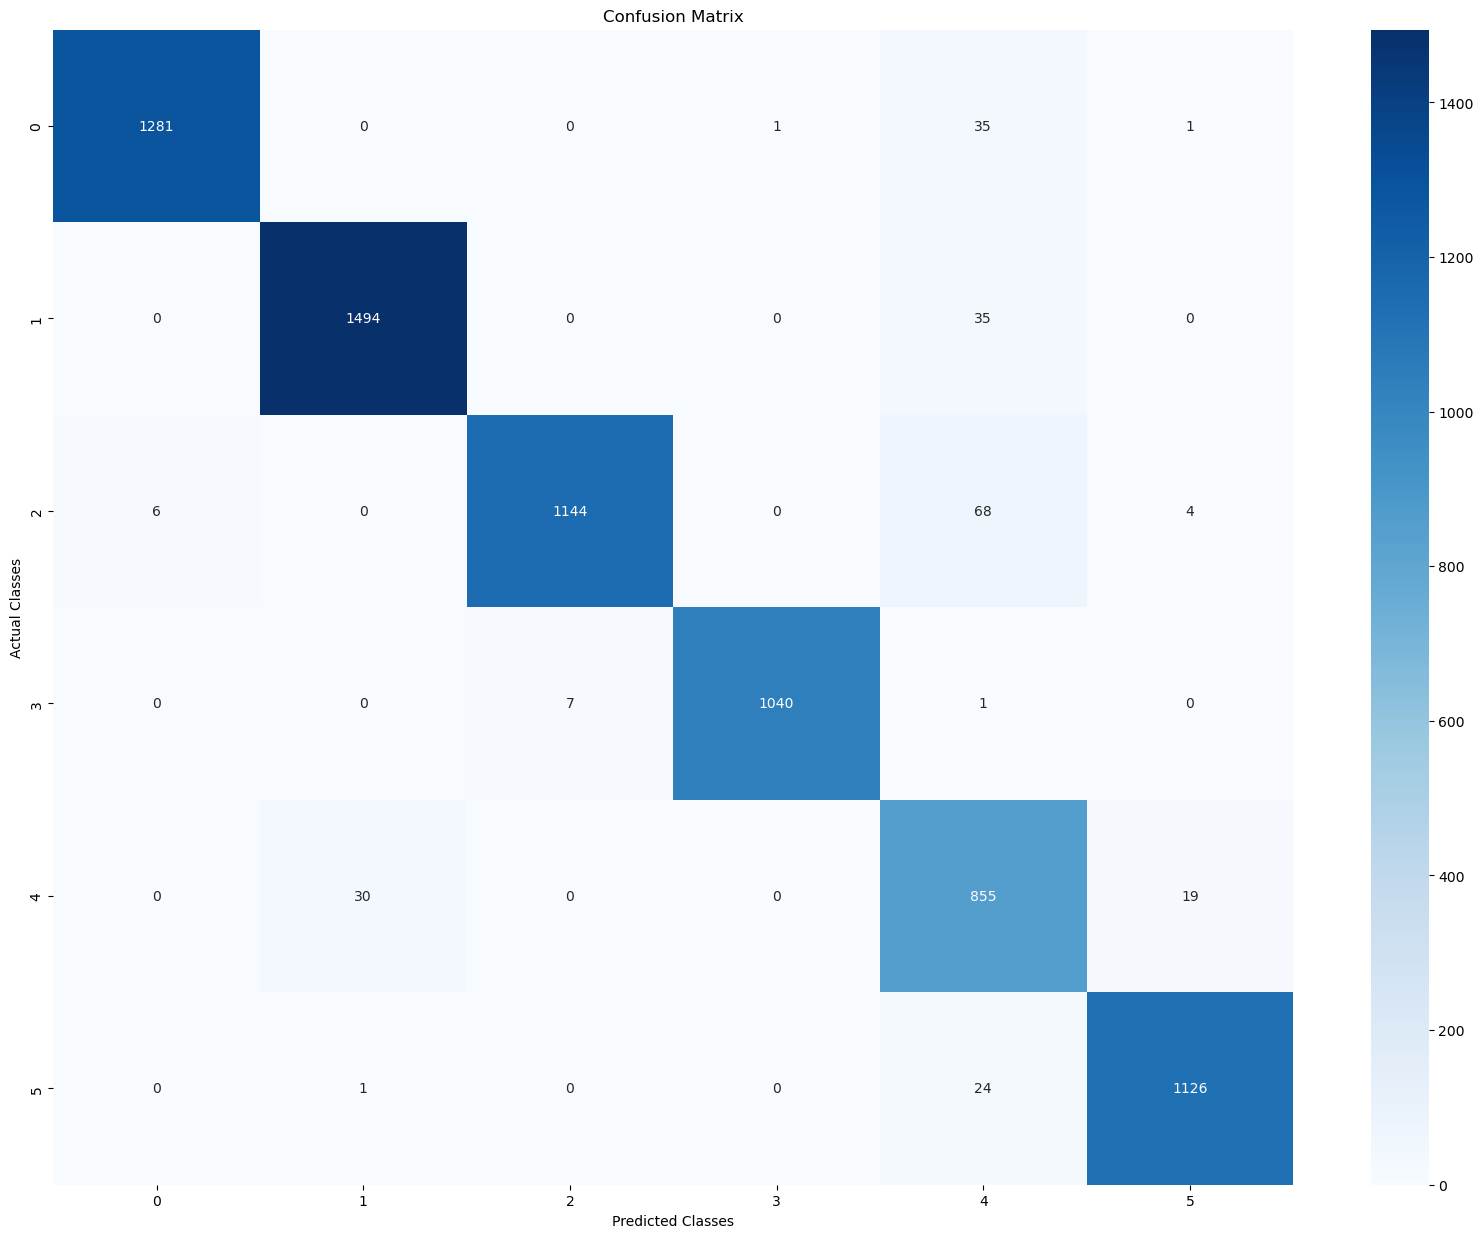

Accuracy Score:
0.9676519799219185


In [17]:
best_fusion_model = DualInputCNN()
best_fusion_model.to(device)
best_fusion_model.load_state_dict(torch.load('best_fusion_model.pth'))
best_fusion_model.to(device)

evaluate_model(best_fusion_model, testloader)

In [18]:
face_path = "/Users/charankumarnara/Downloads/fear.jpg"
face_image = Image.open(face_path)
hand_path = "/Users/charankumarnara/Downloads/alpha_y.jpg"
hand_image = Image.open(hand_path)

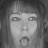

In [19]:
face_image

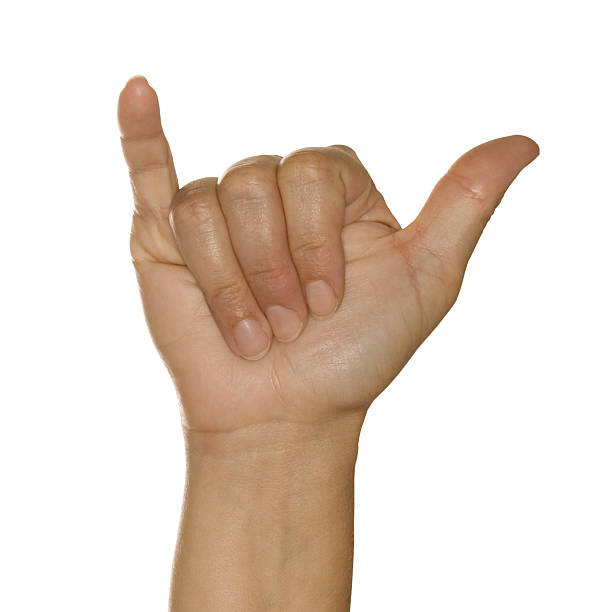

In [20]:
hand_image


In [21]:
hand_image_tensor = test_transform(hand_image)
face_image_tensor = test_transform(face_image)

hand_image_tensor = hand_image_tensor.unsqueeze(0)
face_image_tensor = face_image_tensor.unsqueeze(0)

print("Hand Image Tensor Shape:", hand_image_tensor.shape)
print("Face Image Tensor Shape:", face_image_tensor.shape)

Hand Image Tensor Shape: torch.Size([1, 1, 28, 28])
Face Image Tensor Shape: torch.Size([1, 1, 28, 28])


In [22]:
transform

Compose(
    Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
    ToTensor()
    Grayscale(num_output_channels=1)
    Normalize(mean=(0.5,), std=(0.5,))
)

In [23]:
hand_image_tensor = hand_image_tensor.to(device)
face_image_tensor = face_image_tensor.to(device)

In [24]:
model.eval()  
with torch.no_grad():
    hand_output, face_output = best_fusion_model(hand_image_tensor, face_image_tensor)

In [25]:
hand_probs = F.softmax(hand_output, dim=1)
face_probs = F.softmax(face_output, dim=1)
hand_pred = torch.argmax(hand_probs, dim=1).item()
face_pred = torch.argmax(face_probs, dim=1).item()

In [26]:
hand_pred

19

In [27]:
face_pred

4

In [28]:
hand_probs

tensor([[1.4396e-02, 1.5660e-05, 1.0522e-02, 1.6947e-03, 7.6100e-04, 4.2108e-02,
         1.7503e-02, 2.7355e-03, 1.1497e-03, 5.4526e-05, 3.3676e-05, 4.7749e-05,
         3.4118e-04, 9.1232e-04, 1.8606e-03, 1.0306e-03, 2.6520e-04, 1.2348e-04,
         1.1402e-01, 7.6345e-01, 5.6335e-06, 1.1650e-04, 9.8019e-05, 1.5991e-02,
         1.0764e-02]], device='mps:0')

In [29]:

hand_image_tensor = transform(hand_image).unsqueeze(0)  
face_image_tensor = transform(face_image).unsqueeze(0)
hand_image_tensor = hand_image_tensor.to(device)
face_image_tensor = face_image_tensor.to(device)


model.eval() 
with torch.no_grad():
    hand_output, face_output = best_fusion_model(hand_image_tensor, face_image_tensor)

    _, predicted = torch.max(hand_output, 1)
    print(predicted)


    _, predicted = torch.max(face_output, 1)
    print(predicted)


tensor([19], device='mps:0')
tensor([4], device='mps:0')
